In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Dossier où sont stockés tes fichiers .json
RESULTS_DIR = 'results/'  # ou modifie si besoin

def load_results(results_dir):
    all_results = []
    
    for filename in os.listdir(results_dir):
        if filename.endswith('.json'):
            filepath = os.path.join(results_dir, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)
                
            # Extraire proprement modèle, méthode, facteurs
            method = 'CNN+Transformer' if 'CNN+Transformer' in filename else 'Fourier+NN'
            model = 'FamaFrench' if 'FamaFrench' in filename else 'AvPCA'
            
            if '_1_factors' in filename:
                factors = 1
            elif '_3_factors' in filename:
                factors = 3
            elif '_5_factors' in filename:
                factors = 5
            else:
                factors = 0  # Cas par défaut
            
            all_results.append({
                'Model': model,
                'Factors': factors,
                'Method': method,
                'Sharpe Ratio': data.get('sharpe_ratio', None),
                'Annual Return': data.get('annual_return', None),
                'Annual Volatility': data.get('annual_volatility', None),
                'File Name': filename,
                'Daily Returns': data.get('daily_returns', [])
            })
    
    return pd.DataFrame(all_results)

# Charger
results_df = load_results(RESULTS_DIR)

# Trier les résultats
results_df = results_df.sort_values(by='Sharpe Ratio', ascending=False)

# Afficher
results_df.head()

,Model,Factors,Method,Sharpe Ratio,Annual Return,Annual Volatility,File Name,Daily Returns
4,AvPCA,5,CNN+Transformer,4.216977,0.088030,0.020875,AvPCA_OOSresiduals_5_factors_1998_initialOOSYe...,"[0.00018966072821058333, 0.0015711687738075852..."
2,AvPCA,3,CNN+Transformer,3.999970,0.093073,0.023269,AvPCA_OOSresiduals_3_factors_1998_initialOOSYe...,"[0.0005020491080358624, 0.0020804316736757755,..."
5,AvPCA,5,Fourier+NN,2.821103,0.070270,0.024909,AvPCA_OOSresiduals_5_factors_1998_initialOOSYe...,"[0.0008843407849781215, 0.0003155566519126296,..."
10,FamaFrench,5,CNN+Transformer,2.470444,0.074985,0.030353,DailyFamaFrench_OOSresiduals_5_factors_1998_in...,"[0.00030180683825165033, 0.004065306391566992,..."
8,FamaFrench,3,CNN+Transformer,2.462664,0.074951,0.030435,DailyFamaFrench_OOSresiduals_3_factors_1998_in...,"[-0.0022123202215880156, 0.003232628107070923,..."


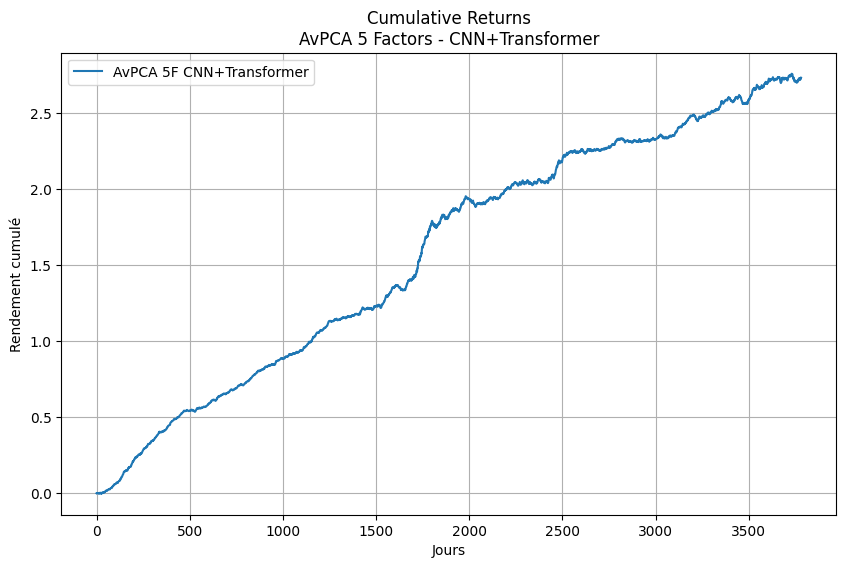

In [4]:
# Tracer rendement cumulé pour un modèle donné
def plot_cumulative_returns(row):
    daily_returns = pd.Series(row['Daily Returns'])
    cumulative_returns = (1 + daily_returns).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label=f"{row['Model']} {row['Factors']}F {row['Method']}")
    plt.title(f"Cumulative Returns\n{row['Model']} {row['Factors']} Factors - {row['Method']}")
    plt.xlabel("Jours")
    plt.ylabel("Rendement cumulé")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple : afficher pour le meilleur modèle Sharpe
plot_cumulative_returns(results_df.iloc[0])

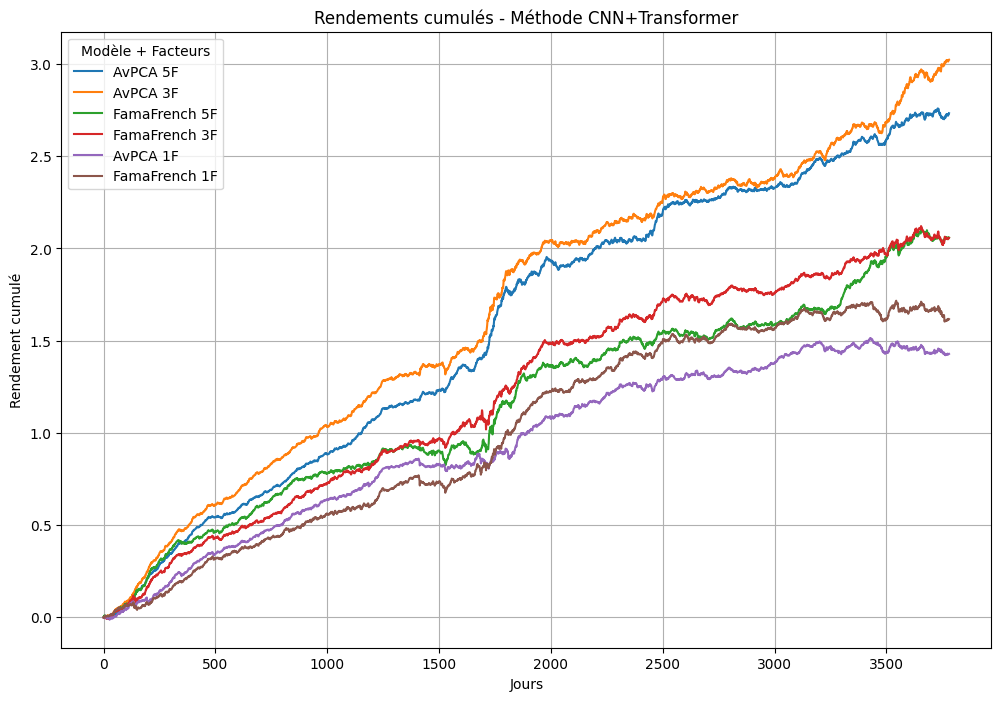

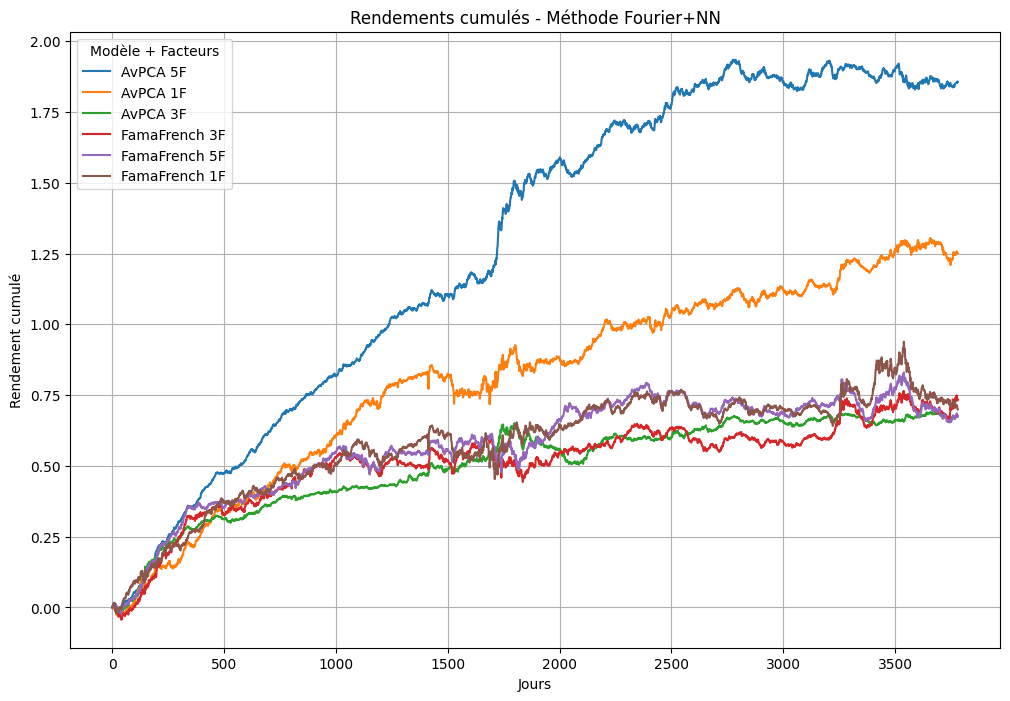

In [5]:
def plot_cumulative_returns_by_method(results_df):
    # Séparer par méthode
    methods = results_df['Method'].unique()
    
    for method in methods:
        subset = results_df[results_df['Method'] == method]
        
        plt.figure(figsize=(12, 8))
        
        for idx, row in subset.iterrows():
            daily_returns = pd.Series(row['Daily Returns'])
            cumulative_returns = (1 + daily_returns).cumprod() - 1
            label = f"{row['Model']} {row['Factors']}F"
            plt.plot(cumulative_returns, label=label)
        
        plt.title(f"Rendements cumulés - Méthode {method}")
        plt.xlabel("Jours")
        plt.ylabel("Rendement cumulé")
        plt.legend(title="Modèle + Facteurs")
        plt.grid(True)
        plt.savefig(f"rendement_cumule_{method}.png", bbox_inches='tight')
        plt.show()

# Utilisation
plot_cumulative_returns_by_method(results_df)

In [6]:
# Tableau résumé : Model - Factors - Method - Sharpe Ratio
sharpe_table = results_df[['Model', 'Factors', 'Method', 'Sharpe Ratio']]

# Trier par Sharpe Ratio décroissant
sharpe_table = sharpe_table.sort_values(by='Sharpe Ratio', ascending=False)

# Afficher
sharpe_table

,Model,Factors,Method,Sharpe Ratio
4,AvPCA,5,CNN+Transformer,4.216977
2,AvPCA,3,CNN+Transformer,3.999970
5,AvPCA,5,Fourier+NN,2.821103
10,FamaFrench,5,CNN+Transformer,2.470444
8,FamaFrench,3,CNN+Transformer,2.462664
0,AvPCA,1,CNN+Transformer,2.114216
6,FamaFrench,1,CNN+Transformer,2.058838
1,AvPCA,1,Fourier+NN,1.292919
3,AvPCA,3,Fourier+NN,1.222758
9,FamaFrench,3,Fourier+NN,0.832303


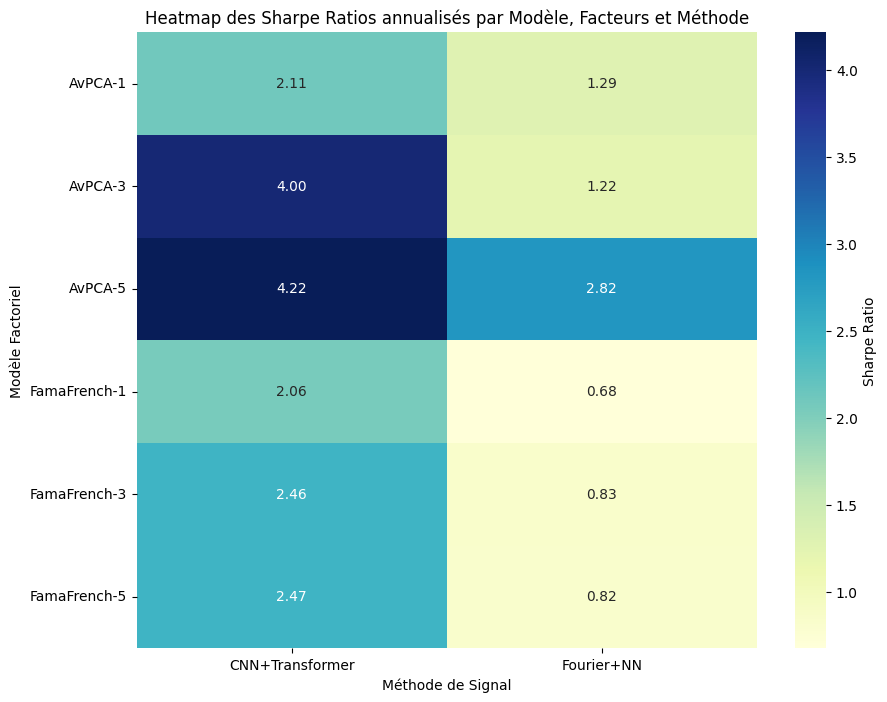

In [7]:
# Préparer un tableau pivoté : 
# lignes = Modèle + Facteurs, colonnes = Méthode, valeurs = Sharpe Ratio
pivot_table = results_df.pivot_table(
    index=['Model', 'Factors'],
    columns='Method',
    values='Sharpe Ratio'
)

# Affichage de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Sharpe Ratio'})

plt.title('Heatmap des Sharpe Ratios annualisés par Modèle, Facteurs et Méthode')
plt.xlabel('Méthode de Signal')
plt.ylabel('Modèle Factoriel')
plt.yticks(rotation=0)
plt.show()